## Mocking

### Definition

**Mock**: *verb*,

1. to tease or laugh at in a scornful or contemptuous manner
2. to make a replica or imitation of something



**Mocking**

- Replace a real object with a pretend object, which records how it is called, and can assert if it is called wrong

### Mocking frameworks

* C: [CMocka](http://www.cmocka.org/)
* C++: [googlemock](https://code.google.com/p/googlemock/)
* Python: [unittest.mock](http://docs.python.org/dev/library/unittest.mock)

### Recording calls with mock

Mock objects record the calls made to them:

In [21]:
from unittest.mock import Mock
function = Mock(name="myroutine", return_value=2)

In [22]:
function(1)

2

In [23]:
function(5, "hello", a=True)

2

In [24]:
function.mock_calls

[call(1), call(5, 'hello', a=True)]

The arguments of each call can be recovered

In [25]:
name, args, kwargs = function.mock_calls[1]
name, args, kwargs

('', (5, 'hello'), {'a': True})

Mock objects can return different values for each call

In [7]:
function = Mock(name="myroutine", side_effect=[2, "xyz"])

In [8]:
function(1)

2

In [9]:
function(1, "hello", {'a': True})

'xyz'

We expect an error if there are no return values left in the list:

In [10]:
function()

StopIteration: 

### Using mocks to model test resources

Often we want to write tests for code which interacts with remote resources. (E.g. databases, the internet, or data files.)

We don't want to have our tests *actually* interact with the remote resource, as this would mean our tests failed
due to lost internet connections, for example.

Instead, we can use mocks to assert that our code does the right thing in terms of the *messages it sends*: the parameters of the
function calls it makes to the remote resource.

For example, consider the following code that downloads a map from the internet:

In [11]:
import requests

def map_at(lat,long, satellite=False, zoom=12, 
           size=(400,400), sensor=False):
    
    base="http://maps.googleapis.com/maps/api/staticmap?"
    
    params=dict(
        sensor= str(sensor).lower(),
        zoom= zoom,
        size= "x".join(map(str,size)),
        center= ",".join(map(str,(lat,long))),
        style="feature:all|element:labels|visibility:off")
    
    if satellite:
        params["maptype"]="satellite"
        
    return requests.get(base,params=params)

In [12]:
london_map=map_at(51.5073509, -0.1277583)
import IPython

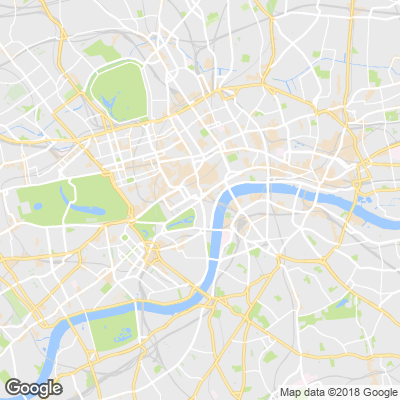

In [13]:
%matplotlib inline
IPython.core.display.Image(london_map.content)

We would like to test that it is building the parameters correctly. We can do this by **mocking** the requests object. We need to temporarily replace a method in the library with a mock. We can use "patch" to do this:

In [14]:
from unittest.mock import patch
with patch.object(requests,'get') as mock_get:
    london_map=map_at(51.5073509, -0.1277583)
    print(mock_get.mock_calls)

[call('http://maps.googleapis.com/maps/api/staticmap?', params={'sensor': 'false', 'zoom': 12, 'size': '400x400', 'center': '51.5073509,-0.1277583', 'style': 'feature:all|element:labels|visibility:off'})]


Our tests then look like:

In [27]:
def test_build_default_params():
    with patch.object(requests,'get') as mock_get:
        default_map=map_at(51.0, 0.0)
        mock_get.assert_called_with(
        "http://maps.googleapis.com/maps/api/staticmap?",
        params={
            'sensor':'false',
            'zoom':12,
            'size':'400x400',
            'center':'51.0,0.0',
            'style':'feature:all|element:labels|visibility:off'
        }
    )
test_build_default_params()

In [70]:
class MyList:
    def __init__(self, elements):
        self.elements = elements
        
    def exponentiate_elements(self, exponent):
        return [pow(e, exponent) for e in self.elements]
    
def square_list(elements):
    lst = MyList(elements)
    return lst.exponentiate_elements(2)

#square_list([1,2,3,4])

def test_exponentiate_input():
    with patch.object(MyList, 'exponentiate_elements') as mock_exp:
        squared_list=square_list([1,2,3,4])
        mock_exp.assert_called_with(2)
        
test_exponentiate_input()        

That was quiet, so it passed. When I'm writing tests, I usually modify one of the expectations, to something 'wrong', just to check it's not
passing "by accident", run the tests, then change it back!

### Testing functions that call other functions

<div align="left">

In [28]:
def partial_derivative(function, at, direction, delta=1.0):
    f_x=function(at)
    x_plus_delta=at[:]
    x_plus_delta[direction]+=delta
    f_x_plus_delta=function(x_plus_delta)
    return (f_x_plus_delta-f_x)/delta

We want to test that the above function does the right thing. It is supposed to compute the derivative of a function
of a vector in a particular direction.

E.g.:

In [17]:
partial_derivative(sum, [0,0,0], 1)

1.0

How do we assert that it is doing the right thing? With tests like this:

In [37]:
from unittest.mock import MagicMock

def test_derivative_2d_y_direction():
    func=MagicMock()
    partial_derivative(func, [0,0], 1)
    func.assert_any_call([0, 1.0])
    func.assert_any_call([0, 0.0])
    

test_derivative_2d_y_direction()

In [75]:
def f(func, in_list):
    return [func(l) for l in in_list]

def test_my_func():
    func = MagicMock()
    f(func, [1,2,3,4])
    func.assert_called_with(4)
    func.assert_any_call(1)

test_my_func()

In [85]:
import math

def sin_power(x, pwr):
    return math.sin(pow(x, pwr))

with patch.object(math, 'sin') as mock_sin:
    sin_power(2,3)
    mock_sin.assert_called_with(8)

We made our mock a "Magic Mock" because otherwise, the mock results `f_x_plus_delta` and `f_x` can't be subtracted:

In [19]:
MagicMock()-MagicMock()

<MagicMock name='mock.__sub__()' id='2295172443048'>

In [20]:
Mock()-Mock()

TypeError: unsupported operand type(s) for -: 'Mock' and 'Mock'